In [5]:
import tensorflow as tf # Machine learning library
from tensorflow import keras # Library for neural networks
import numpy as np # Scientific computing library
import cv2 # Computer vision library
import glob # Filename handling library
 
# Inception V3 model for Keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
 
# To detect objects, we will use a pretrained neural network that has been 
# trained on the COCO data set. You can read more about this data set here: 
#   https://content.alegion.com/datasets/coco-ms-coco-dataset
# COCO labels are here: https://github.com/tensorflow/models/blob/master/research/object_detection/data/mscoco_label_map.pbtxt

LABEL_PERSON = 1
LABEL_CAR = 3
LABEL_BUS = 6
LABEL_TRUCK = 8
LABEL_TRAFFIC_LIGHT = 10
LABEL_STOP_SIGN = 13
 
def accept_box(boxes, box_index, tolerance):
  """
  Eliminate duplicate bounding boxes.
  """
  box = boxes[box_index]
 
  for idx in range(box_index):
    other_box = boxes[idx]
    if abs(center(other_box, "x") - center(box, "x")) < tolerance and abs(center(other_box, "y") - center(box, "y")) < tolerance:
      return False
 
  return True
 
def get_files(pattern):
  """
  Create a list of all the images in a directory
     
  :param:pattern str The pattern of the filenames
  :return: A list of the files that match the specified pattern 
  """
  files = []
 
  # For each file that matches the specified pattern
  for file_name in glob.iglob(pattern, recursive=True):
 
    # Add the image file to the list of files
    files.append(file_name)
 
  # Return the complete file list
  return files
     
def load_model(model_name):
  """
  Download a pretrained object detection model, and save it to your hard drive.
  :param:str Name of the pretrained object detection model
  """
  url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + model_name + '.tar.gz'
     
  # Download a file from a URL that is not already in the cache
  model_dir = tf.keras.utils.get_file(fname=model_name, untar=True, origin=url)
 
  print("Model path: ", str(model_dir))
   
  model_dir = str(model_dir) + "/saved_model"
  model = tf.saved_model.load(str(model_dir))
 
  return model
 
def load_rgb_images(pattern, shape=None):
  """
  Loads the images in RGB format.
     
  :param:pattern str The pattern of the filenames
  :param:shape Image dimensions (width, height)
  """
  # Get a list of all the image files in a directory
  files = get_files(pattern)
 
  # For each image in the directory, convert it from BGR format to RGB format
  images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in files]
 
  # Resize the image if the desired shape is provided
  if shape:
    return [cv2.resize(img, shape) for img in images]
  else:
    return images
 
def load_ssd_coco():
  """
  Load the neural network that has the SSD architecture, trained on the COCO
  data set.
  """
  return load_model("ssd_resnet50_v1_fpn_640x640_coco17_tpu-8")
 
def save_image_annotated(img_rgb, file_name, output, model_traffic_lights=None):
  """
  Annotate the image with the object types, and generate cropped images of
  traffic lights.
  """
  # Create annotated image file 
  output_file = file_name.replace('.jpg', '_test.jpg')
     
  # For each bounding box that was detected  
  for idx in range(len(output['boxes'])):
 
    # Extract the type of the object that was detected
    obj_class = output["detection_classes"][idx]
     
    # How confident the object detection model is on the object's type
    score = int(output["detection_scores"][idx] * 100)

    if score >= 28 :
      # Extract the bounding box
      box = output["boxes"][idx]
  
      color = None
      label_text = ""

      if obj_class == LABEL_PERSON:
        color = (0, 255, 255)
        label_text = "Person " + str(score)

      if obj_class == LABEL_CAR:
        color = (255, 255, 0)
        label_text = "Car " + str(score)

      if obj_class == LABEL_BUS:
        color = (255, 255, 0)
        label_text = "Bus " + str(score)

      if obj_class == LABEL_TRUCK:
        color = (255, 255, 0)
        label_text = "Truck " + str(score)
        
      
      if obj_class == LABEL_STOP_SIGN:
        color = (128, 0, 0)
        label_text = "Stop Sign " + str(score)
      if obj_class == LABEL_TRAFFIC_LIGHT:
        color = (255, 255, 255)
        label_text = "Traffic Light " + str(score)
              
        if model_traffic_lights:
                # Annotate the image and save it
          img_traffic_light = img_rgb[box["y"]:box["y2"], box["x"]:box["x2"]]
          img_inception = cv2.resize(img_traffic_light, (299, 299))
          
                  # Uncomment this if you want to save a cropped image of the traffic light
          #cv2.imwrite(output_file.replace('.jpg', '_crop.jpg'), cv2.cvtColor(img_inception, cv2.COLOR_RGB2BGR))
          img_inception = np.array([preprocess_input(img_inception)])
  
          prediction = model_traffic_lights.predict(img_inception)
          label = np.argmax(prediction)
          score_light = str(int(np.max(prediction) * 100))
          if label == 0:
            label_text = "Green " + score_light
          elif label == 1:
            label_text = "Yellow " + score_light
          elif label == 2:
            label_text = "Red " + score_light
          else:
            label_text = 'NO-LIGHT'  # This is not a traffic light
      
      if color and label_text and accept_box(output["boxes"], idx, 5.0) :
        cv2.rectangle(img_rgb, (box["x"], box["y"]), (box["x2"], box["y2"]), color, 2)
        cv2.putText(img_rgb, label_text, (box["x"], box["y"]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
  
    cv2.imwrite(output_file, cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
 
def center(box, coord_type):
  """
  Get center of the bounding box.
  """
  return (box[coord_type] + box[coord_type + "2"]) / 2
 
def perform_object_detection(model, file_name, save_annotated=False, model_traffic_lights=None):
  """
  Perform object detection on an image using the predefined neural network.
  """
  # Store the image
  img_bgr = cv2.imread(file_name)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  input_tensor = tf.convert_to_tensor(img_rgb) # Input needs to be a tensor
  input_tensor = input_tensor[tf.newaxis, ...]
 
  # Run the model
  output = model(input_tensor)
 
  print("num_detections:", output['num_detections'], int(output['num_detections']))
 
  # Convert the tensors to a NumPy array
  num_detections = int(output.pop('num_detections'))
  output = {key: value[0, :num_detections].numpy()
            for key, value in output.items()}
  output['num_detections'] = num_detections
 
  # The detected classes need to be integers.
  output['detection_classes'] = output['detection_classes'].astype(np.int64)
  output['boxes'] = [
    {"y": int(box[0] * img_rgb.shape[0]), "x": int(box[1] * img_rgb.shape[1]), "y2": int(box[2] * img_rgb.shape[0]),
     "x2": int(box[3] * img_rgb.shape[1])} for box in output['detection_boxes']]
 
  if save_annotated:
    save_image_annotated(img_rgb, file_name, output, model_traffic_lights)
 
  return img_rgb, output, file_name
     
def perform_object_detection_video(model, video_frame, model_traffic_lights=None):
  """
  Perform object detection on a video using the predefined neural network.
     
  Returns the annotated video frame.
  """
  # Store the image
  img_rgb = cv2.cvtColor(video_frame, cv2.COLOR_BGR2RGB)
  input_tensor = tf.convert_to_tensor(img_rgb) # Input needs to be a tensor
  input_tensor = input_tensor[tf.newaxis, ...]
 
  # Run the model
  output = model(input_tensor)
 
  # Convert the tensors to a NumPy array
  num_detections = int(output.pop('num_detections'))
  output = {key: value[0, :num_detections].numpy()
            for key, value in output.items()}
  output['num_detections'] = num_detections
 
  # The detected classes need to be integers.
  output['detection_classes'] = output['detection_classes'].astype(np.int64)
  output['boxes'] = [
    {"y": int(box[0] * img_rgb.shape[0]), "x": int(box[1] * img_rgb.shape[1]), "y2": int(box[2] * img_rgb.shape[0]),
     "x2": int(box[3] * img_rgb.shape[1])} for box in output['detection_boxes']]
 
  # For each bounding box that was detected  
  for idx in range(len(output['boxes'])):
 
    # Extract the type of the object that was detected
    obj_class = output["detection_classes"][idx]
     
    # How confident the object detection model is on the object's type
    score = int(output["detection_scores"][idx] * 100)
         
    # Extract the bounding box
    box = output["boxes"][idx]
 
    color = None
    label_text = ""
    
    if obj_class == LABEL_TRAFFIC_LIGHT:
      color = (255, 255, 255)
      label_text = "Traffic Light " + str(score)
             
      if model_traffic_lights and score >= 20:
       
              # Annotate the image and save it
        img_traffic_light = img_rgb[box["y"]:box["y2"], box["x"]:box["x2"]]
        img_inception = cv2.resize(img_traffic_light, (299, 299))
         
        img_inception = np.array([preprocess_input(img_inception)])
 
        prediction = model_traffic_lights.predict(img_inception)
        label = np.argmax(prediction)
        score_light = str(int(np.max(prediction) * 100))
        if label == 0:
          label_text = "Green " + score_light
          color = (0, 255, 26)
        elif label == 1:
          label_text = "Yellow " + score_light
          color = (255, 245, 46)
        elif label == 2:
          label_text = "Red " + score_light
          color = (255, 0, 0)
        else:
          label_text = 'NO-LIGHT'  # This is not a traffic light
 
    # Use the score variable to indicate how confident we are it is a traffic light (in % terms)
    # On the actual video frame, we display the confidence that the light is either red, green,
    # yellow, or not a valid traffic light.
    if color and label_text and accept_box(output["boxes"], idx, 5.0) and score >= 20:
      cv2.rectangle(img_rgb, (box["x"], box["y"]), (box["x2"], box["y2"]), color, 2)
      cv2.putText(img_rgb, label_text, (box["x"], box["y"]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
 
  output_frame = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
  return output_frame
 
def double_shuffle(images, labels):
  """
  Shuffle the images to add some randomness.
  """
  indexes = np.random.permutation(len(images))
 
  return [images[idx] for idx in indexes], [labels[idx] for idx in indexes]
 
def reverse_preprocess_inception(img_preprocessed):
  """
  Reverse the preprocessing process.
  """
  img = img_preprocessed + 1.0
  img = img * 127.5
  return img.astype(np.uint8)

In [3]:
# Get a list of jpeg image files containing traffic lights
files = get_files("./train_images/*")
 
# Load the object detection model
this_model = load_ssd_coco()
 
# Keep track of the number of traffic lights found
traffic_light_count = 0
 
# Keep track of the number of image files that were processed
file_count = 0
 
# Display a count of the number of images we need to process
print("Number of Images:", len(files))
 
# Go through each image file, one at a time
for file in files:
 
  # Detect objects in the image
  # img_rgb is the original image in RGB format
  # out is a dictionary containing the results of object detection
  # file_name is the name of the file
  (img_rgb, out, file_name) = perform_object_detection(model=this_model, file_name=file, save_annotated=None, model_traffic_lights=None)
     
  # Every 10 files that are processed
  if (file_count % 10) == 0:
 
    # Display a count of the number of files that have been processed
    print("Images processed:", file_count)
 
    # Display the total number of traffic lights that have been identified so far
    print("Number of Traffic lights identified: ", traffic_light_count)
         
  # Increment the number of files by 1
  file_count = file_count + 1
 
  # For each traffic light (i.e. bounding box) that was detected
  for idx in range(len(out['boxes'])):
 
    # Extract the type of object that was detected  
    obj_class = out["detection_classes"][idx]

    # If the object that was detected is a traffic light
    if obj_class == LABEL_TRAFFIC_LIGHT and out["detection_scores"][idx] >= 0.28:
         
      # Extract the coordinates of the bounding box
      box = out["boxes"][idx]
             
      # Extract (i.e. crop) the traffic light from the image     
      traffic_light = img_rgb[box["y"]:box["y2"], box["x"]:box["x2"]]
             
      # Convert the traffic light from RGB format into BGR format
      traffic_light = cv2.cvtColor(traffic_light, cv2.COLOR_RGB2BGR)
 
      # Store the cropped image in a folder named 'traffic_light_cropped'     
      cv2.imwrite("./traffic_light_cropped/" + str(traffic_light_count) + ".jpg", traffic_light)
             
      # Increment the number of traffic lights by 1
      traffic_light_count = traffic_light_count + 1
 
# Display the total number of traffic lights identified
print("Number of Traffic lights identified:", traffic_light_count)

Model path:  C:\Users\mende\.keras\datasets\ssd_resnet50_v1_fpn_640x640_coco17_tpu-8
Number of Images: 2600
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
Images processed: 0
Number of Traffic lights identified:  0
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
num_detections: tf.Tensor([100.], shape=(1,), dtype=float32) 100
Images processed: 10
Number of Traffic lights identified:  15
num_detections: tf.Tensor([100.], shape=(1,), dtype=flo

TensorFlow 2.11.0
Keras 2.11.0
Images:  1000
Labels:  1000
Labels: Counter({1: 250, 3: 250, 0: 250, 2: 250})
0: 250
1: 250
2: 250
3: 250
Class weight: {0: 4.0, 1: 4.0, 2: 4.0, 3: 4.0}
Loading Inception V3...
Inception V3 has finished loading.
Layers:  311
Shape: (8, 8, 2048)
Shape: (None, 8, 8, 2048)
Shape: [<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'mixed10')>]
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']       

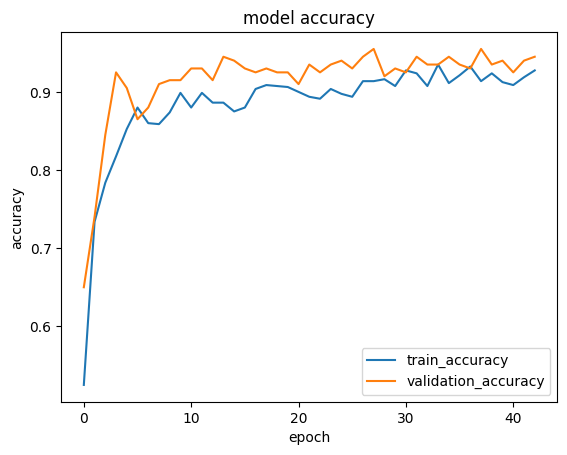

Validation loss: 0.185050368309021
Validation accuracy: 0.9449999928474426
Saving the validation data set...
Length of the validation data set: 200
1/1 [==============================] - 0s 133ms/step
The validation data set has been saved!


In [5]:
# Description: This program trains a neural network to detect the color
#   of a traffic light. Performance on the validation data set is saved
#   to a directory. Also, the best neural network model is saved as
#   traffic.h5.

import collections # Handles specialized container datatypes
import cv2 # Computer vision library
import matplotlib.pyplot as plt # Plotting library
import numpy as np # Scientific computing library
import object_detection # Custom object detection program
import sys
import tensorflow as tf # Machine learning library
from tensorflow import keras # Library for neural networks
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
 
# Show the version of TensorFlow and Keras that I am using
print("TensorFlow", tf.__version__)
print("Keras", keras.__version__)
 
def show_history(history):
  """
  Visualize the neural network model training history
   
  :param:history A record of training loss values and metrics values at 
                 successive epochs, as well as validation loss values 
                 and validation metrics values
  """
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
  plt.show()
 
def Transfer(n_classes, freeze_layers=True):
  """
  Use the InceptionV3 neural network architecture to perform transfer learning.
     
  :param:n_classes Number of classes
  :param:freeze_layers If True, the network's parameters don't change.
  :return The best neural network
  """
  print("Loading Inception V3...")
 
  # To understand what the parameters mean, do a Google search 'inceptionv3 keras'. 
  # The first search result should send you to the Keras website, which has an 
  # explanation of what each of these parameters mean.
  # input_top means we are removing the top part of the Inception model, which is the 
  # classifier. 
  # input_shape needs to have 3 channels, and needs to be at least 75x75 for the
  # resolution.
  # Our neural network will build off of the Inception V3 model (trained on the ImageNet
  # data set).
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
 
  print("Inception V3 has finished loading.")
 
  # Display the base network architecture
  print('Layers: ', len(base_model.layers))
  print("Shape:", base_model.output_shape[1:])
  print("Shape:", base_model.output_shape)
  print("Shape:", base_model.outputs)
  base_model.summary()
 
  # Create the neural network. This network uses the Sequential
  # architecture where each layer has one 
  # input tensor (e.g. vector, matrix, etc.) and one output tensor 
  top_model = Sequential()
 
  # Our classifier model will build on top of the base model
  top_model.add(base_model)
  top_model.add(GlobalAveragePooling2D())
  top_model.add(Dropout(0.5))
  top_model.add(Dense(1024, activation='relu'))
  top_model.add(BatchNormalization())
  top_model.add(Dropout(0.5))
  top_model.add(Dense(512, activation='relu'))
  top_model.add(Dropout(0.5))
  top_model.add(Dense(128, activation='relu'))
  top_model.add(Dense(n_classes, activation='softmax'))
 
  # Freeze layers in the model so that they cannot be trained (i.e. the
  # parameters in the neural network will not change)
  if freeze_layers:
    for layer in base_model.layers:
      layer.trainable = False
 
  return top_model
 
# Perform image augmentation. 
# Image augmentation enables us to alter the available images
# (e.g. rotate, flip, changing the hue, etc.) to generate more images that our
# neural network can use for training...therefore preventing us from having to
# collect more external images.
datagen = ImageDataGenerator(rotation_range=5, width_shift_range=[-10, -5, -2, 0, 2, 5, 10],
                             zoom_range=[0.7, 1.5], height_shift_range=[-10, -5, -2, 0, 2, 5, 10],
                             horizontal_flip=True)
 
shape = (299, 299)
 
# Load the cropped traffic light images from the appropriate directory
img_0_green = load_rgb_images("./data/0_green/*", shape)
img_1_yellow = load_rgb_images("./data/1_yellow/*", shape)
img_2_red = load_rgb_images("./data/2_red/*", shape)
img_3_not_traffic_light = load_rgb_images("./data/3_not/*", shape)
 
# Create a list of the labels that is the same length as the number of images in each
# category
# 0 = green
# 1 = yellow
# 2 = red
# 3 = not a traffic light
labels = [0] * len(img_0_green)
labels.extend([1] * len(img_1_yellow))
labels.extend([2] * len(img_2_red))
labels.extend([3] * len(img_3_not_traffic_light))
 
# Create NumPy array
labels_np = np.ndarray(shape=(len(labels), 4))
images_np = np.ndarray(shape=(len(labels), shape[0], shape[1], 3))
 
# Create a list of all the images in the traffic lights data set
img_all = []
img_all.extend(img_0_green)
img_all.extend(img_1_yellow)
img_all.extend(img_2_red)
img_all.extend(img_3_not_traffic_light)
 
# Make sure we have the same number of images as we have labels
assert len(img_all) == len(labels)  
 
# Shuffle the images
img_all = [preprocess_input(img) for img in img_all]
(img_all, labels) = double_shuffle(img_all, labels)
 
# Store images and labels in a NumPy array
for idx in range(len(labels)):
  images_np[idx] = img_all[idx]
  labels_np[idx] = labels[idx]
     
print("Images: ", len(img_all))
print("Labels: ", len(labels))
 
# Perform one-hot encoding
for idx in range(len(labels_np)):
  # We have four integer labels, representing the different colors of the 
  # traffic lights.
  labels_np[idx] = np.array(to_categorical(labels[idx], 4))
     
# Split the data set into a training set and a validation set
# The training set is the portion of the data set that is used to 
#   determine the parameters (e.g. weights) of the neural network.
# The validation set is the portion of the data set used to
#   fine tune the model-specific parameters (i.e. hyperparameters) that are 
#   fixed before you train and test your neural network on the data. The 
#   validation set helps us select the final model (e.g. learning rate, 
#   number of hidden layers, number of hidden units, activation functions, 
#   number of epochs, etc.
# In this case, 80% of the data set becomes training data, and 20% of the
# data set becomes validation data.
idx_split = int(len(labels_np) * 0.8)
x_train = images_np[0:idx_split]
x_valid = images_np[idx_split:]
y_train = labels_np[0:idx_split]
y_valid = labels_np[idx_split:]
 
# Store a count of the number of traffic lights of each color
cnt = collections.Counter(labels)
print('Labels:', cnt)
n = len(labels)
print('0:', cnt[0])
print('1:', cnt[1])
print('2:', cnt[2])
print('3:', cnt[3])
 
# Calculate the weighting of each traffic light class
class_weight = {0: n / cnt[0], 1: n / cnt[1], 2: n / cnt[2], 3: n / cnt[3]}
print('Class weight:', class_weight)
 
# Save the best model as traffic.h5
checkpoint = ModelCheckpoint("traffic.h5", monitor='val_loss', mode='min', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(min_delta=0.0005, patience=15, verbose=1)
 
# Generate model using transfer learning
model = Transfer(n_classes=4, freeze_layers=True)
 
# Display a summary of the neural network model
model.summary()
 
# Generate a batch of randomly transformed images 
it_train = datagen.flow(x_train, y_train, batch_size=32)
 
# Configure the model parameters for training
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
 
# Train the model on the image batches for a fixed number of epochs
# Store a record of the error on the training data set and metrics values
#   in the history object.
history_object = model.fit(it_train, epochs=250, validation_data=(
  x_valid, y_valid), shuffle=True, callbacks=[
  checkpoint, early_stopping], class_weight=class_weight)
 
# Display the training history
show_history(history_object)
 
# Get the loss value and metrics values on the validation data set
score = model.evaluate(x_valid, y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])
 
print('Saving the validation data set...')
 
print('Length of the validation data set:', len(x_valid))
 
# Go through the validation data set, and see how the model did on each image
for idx in range(len(x_valid)):
 
  # Make the image a NumPy array
  img_as_ar = np.array([x_valid[idx]])
 
  # Generate predictions    
  prediction = model.predict(img_as_ar)
 
  # Determine what the label is based on the highest probability
  label = np.argmax(prediction)
 
  # Create the name of the directory and the file for the validation data set
  # After each run, delete this out_valid/ directory so that old files are not
  # hanging around in there.
  file_name = str(idx) + "_" + str(label) + "_" + str(np.argmax(str(y_valid[idx]))) + ".jpg"
  img = img_as_ar[0]
 
  # Reverse the image preprocessing process
  img = reverse_preprocess_inception(img)
 
  # Save the image file
  cv2.imwrite(file_name, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
 
print('The validation data set has been saved!')